In [1]:
import networkx as nx

# import dynetworkx as dnx
import dynetx as dn
# import tnetwork as tn
# import pathpy as pp

import pickle
import glob

import numpy as np
import pandas as pd
import seaborn as sns

%matplotlib inline
# %matplotlib widget
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import plotly.graph_objs as go

In [2]:
def read_pickled_object(filename):
    with open(filename, 'rb') as inp:
        obj = pickle.load(inp)
    return obj

## Analysis

In [3]:
def plot_graph_mpl(G):

    # Get node coordinates and edge weights for contacts inside the cell only
    node_positions = {node: data['coordinates'] for node, data in G.nodes(data=True)}
    edges = [(node1, node2, data)
             for node1, node2, translation, data in G.edges(data=True, keys=True)
             if translation == (0, 0, 0)]

    # Create 3D scatter plot
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    # Plot nodes with annotations
    for node, pos in node_positions.items():
        ax.scatter(pos[0], pos[1], pos[2], color='navy', s=120)
        ax.text(pos[0], pos[1], pos[2], str(node), color='white', fontsize=9, ha='center',
                # bbox=dict(facecolor='white', edgecolor='none', alpha=0.85)
               )

    # Plot edges with varying widths based on weight attribute
    for edge in edges:
        node1, node2, data = edge
        pos1 = node_positions[node1]
        pos2 = node_positions[node2]
        weight = data['weight']
        ax.plot([pos1[0], pos2[0]], [pos1[1], pos2[1]], [pos1[2], pos2[2]], linewidth=5*weight, color='black')

    # Set labels and title
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_title('3D Scatter Plot with Edges')

In [4]:
class TemporalNetworkAnalysis:

    def __init__(self, data_list: list):

        G_list = [data['G'] for data in data_list]
        nodes_list = [pd.DataFrame(data['nodes_data']) for data in data_list]

        self.dG = self._create_dynamic_graph(G_list)
        self.__G0 = G_list[0] # first graph in a list used for dynamic graph construction
        self._create_weighted_static_graph()
        self._collect_nodes_list_data(nodes_list)

    def _create_dynamic_graph(self, G_list):
        """
        Create dynamic graph object from a list of snapshot graphs
        """
        dynamic_G = dn.DynGraph()
        for i, snapshot_G in enumerate(G_list):
            dynamic_G.add_interactions_from(snapshot_G.edges(data=True), t=i)

        return dynamic_G

    def _create_weighted_static_graph(self):
        """
        Create static representation of the dynamic graph as a weighted graph
        """
        self.wsG = self.__G0.copy()

        self._econtributions = [(e, self.dG.edge_contribution(*e)) for e in self.dG.edges]
        weights_dict = {(e[0], e[1]): c for e, c in self._econtributions} | {(e[1], e[0]): c for e, c in self._econtributions}

        for edge in self.wsG.edges(keys=True):
            n1, n2, translation = edge
            weight = weights_dict.get((n1, n2), None)
            if weight is not None:
                self.wsG.add_edge(n1, n2, key=translation, weight=weight)
            else:
                print(edge, '!!!')

    def _collect_nodes_list_data(self, nodes_list):
        """
        Combine the node VDP characteristics from each frame into a single dataframe
        """
        df = pd.concat(nodes_list, axis=1).T
        df = df.astype({
            'frame': 'int32',
            'neighbours_SA_CV': 'float',
            'N_direct_neighbours': 'int8',
            'N_indirect_neighbours': 'int8',
            'N_neighbours': 'int8',
            'neighbours_indices': 'object',
            'MCN': 'int8',
            })
        self.node_characteristics = df

    def show_edge_contribution_info(self, plot_edge_weigts=True, return_persistence_df=False):
        """
        Show data on the edge persistence
        """
        df = pd.DataFrame(self._econtributions, columns=['edge', 'p']).sort_values(by='p', ascending=False)

        if plot_edge_weigts:
            fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 4), sharex=True)
            df['p'].hist(bins=40, density=False, ax=ax1)
            ax1.set_title('Edge persistence histogram')
            ax1.set_xlabel('persistence')
            ax1.set_xlim(-0.01, 1.01)
            data_sorted = np.sort(df['p'].values)
            y = np.arange(len(data_sorted)) / len(data_sorted)
            ax2.set_title('Edge persistence CDF')
            ax2.plot(data_sorted, y, 'k-', lw=2.5)
            ax2.set_xlabel('persistence')
            plt.show()

        if return_persistence_df:
            return df

    def get_filtered_weighted_static_graph(self, edge_weight_threshold=0.9):
        """
        Return graph with edges filtered to have weight >= edge_weight_threshold.
        Nodes are taken from the first snapshot graph in the G_list
        """

        filtered_wsG = self.wsG.copy()
        filtered_wsG.remove_edges_from(list(filtered_wsG.edges()))

        for edge in self.wsG.edges(keys=True, data=True):
            n1, n2, translation, data = edge
            if data['weight'] >= edge_weight_threshold:
                filtered_wsG.add_edge(n1, n2, key=translation, weight=data['weight'])

        return filtered_wsG

In [5]:
data_list = read_pickled_object('MDTopAnalysis_water_md_full.nxg') # MDTopAnalysis_py1mdc MDTopAnalysis_water_md MDTopAnalysis_benzoquinone MDTopAnalysis_water_md_full MDTopAnalysis_glucmdc_420K

In [6]:
tn_analysis = TemporalNetworkAnalysis(data_list)

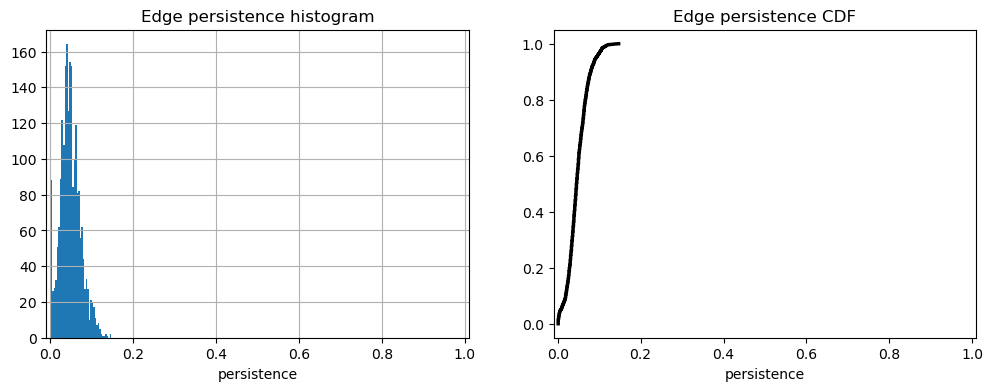

In [7]:
tn_analysis.show_edge_contribution_info(plot_edge_weigts=True, return_persistence_df=False)

In [8]:
ROLLING_MEAN_PERIODS = 25
N_FRAMES = tn_analysis.node_characteristics['frame'].unique()

df_vdp_mean_std =  tn_analysis.node_characteristics.groupby('frame')[
    ['neighbours_SA_CV', 'N_direct_neighbours', 'N_indirect_neighbours', 'N_neighbours', 'MCN']
].agg(['mean', 'std'])

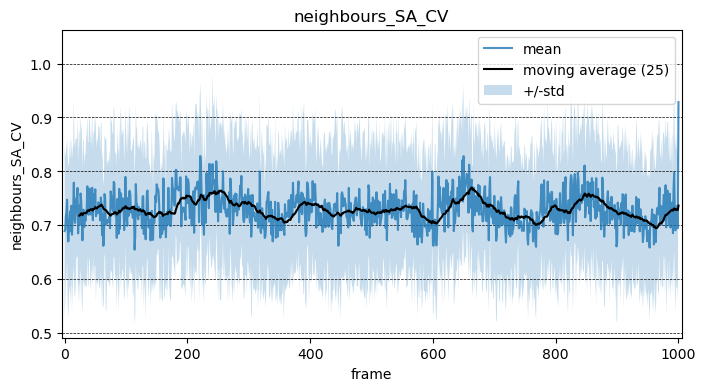

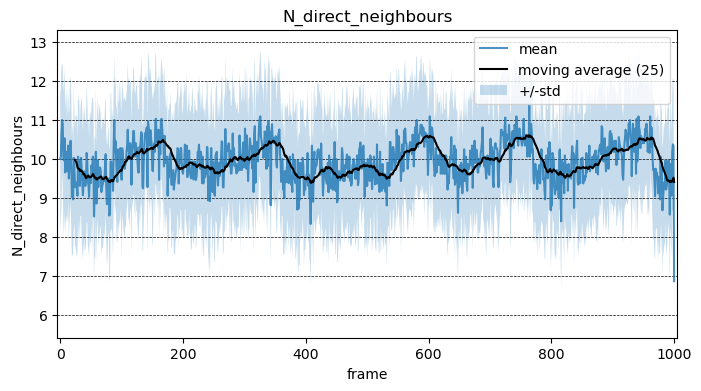

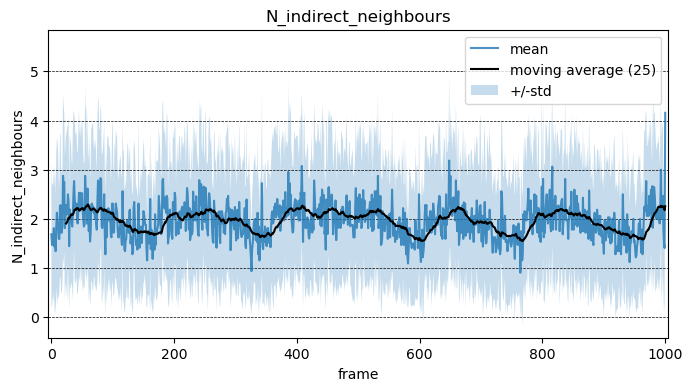

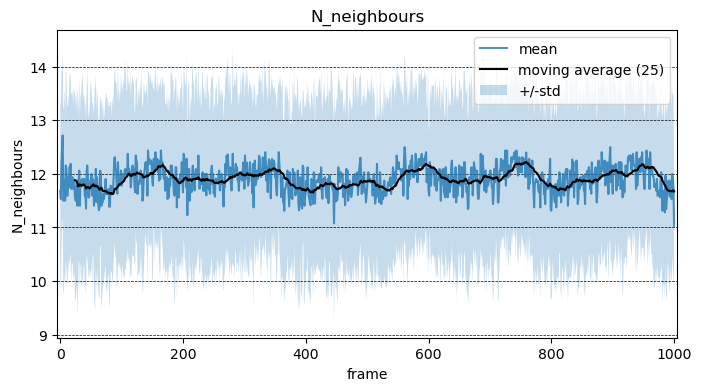

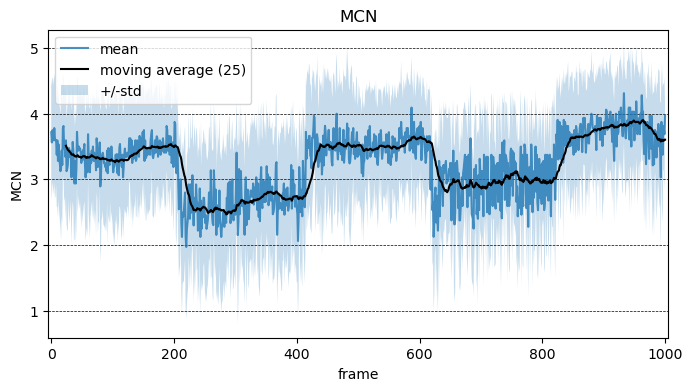

In [9]:
for descriptor in ['neighbours_SA_CV', 'N_direct_neighbours', 'N_indirect_neighbours', 'N_neighbours', 'MCN']:
    plt.figure(figsize=(8, 4))
    plt.title(descriptor)
    plt.grid(visible=True, axis='y', color='k', linestyle='--', linewidth=0.5)
    plt.plot(df_vdp_mean_std[(descriptor, 'mean')], alpha=0.8, label='mean')
    plt.plot(df_vdp_mean_std[(descriptor, 'mean')].rolling(ROLLING_MEAN_PERIODS).mean(),
             color='k', alpha=1.0, label=f'moving average ({ROLLING_MEAN_PERIODS})')
    plt.fill_between(
        N_FRAMES,
        df_vdp_mean_std[(descriptor, 'mean')] - df_vdp_mean_std[(descriptor, 'std')],
        df_vdp_mean_std[(descriptor, 'mean')] + df_vdp_mean_std[(descriptor, 'std')],
        alpha=0.25,
        label='+/-std'
    )
    plt.xlim(-5, N_FRAMES.max() + 5)
    plt.xlabel('frame')
    plt.ylabel(descriptor)
    plt.legend()
    plt.show()

In [32]:
fwsG = tn_analysis.get_filtered_weighted_static_graph(edge_weight_threshold=0.33)

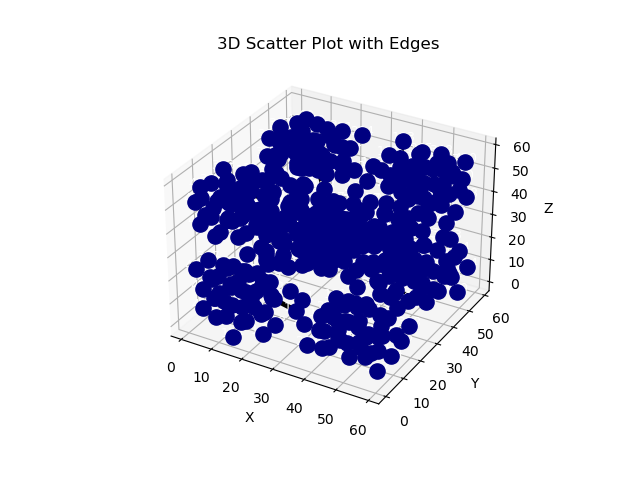

In [34]:
plot_graph_mpl(fwsG)

## valence bond connectivity file preparation 

In [12]:
with open('water_md_connectivity.cif', 'r') as inp:
    content = inp.readlines()

In [13]:
for i, line in enumerate(content):
    if line.startswith('_topol_link.multiplicity'):
        connectivity_data_start_line = i + 1

In [14]:
connectivity_lines = [l.strip() for l in content[connectivity_data_start_line:-1] if ' v ' in l]

In [16]:
vconnectivity = []

for l in connectivity_lines:
    i, j, *_ = l.split()
    i = int(i) - 1
    j = int(j) - 1
    vconnectivity.append((i, j))

In [17]:
len(vconnectivity)

128

In [18]:
vconnectivity = set(vconnectivity)

In [19]:
with open('water_md_full.vconnectivity', 'wb') as out:
    pickle.dump(vconnectivity, out)

In [ ]:
vconnectivity